In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
import seaborn as sns
from ipywidgets import interact
import ipywidgets as widgets

%matplotlib inline

In [2]:
df = datasets.load_iris(as_frame=True)['frame']

In [3]:
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


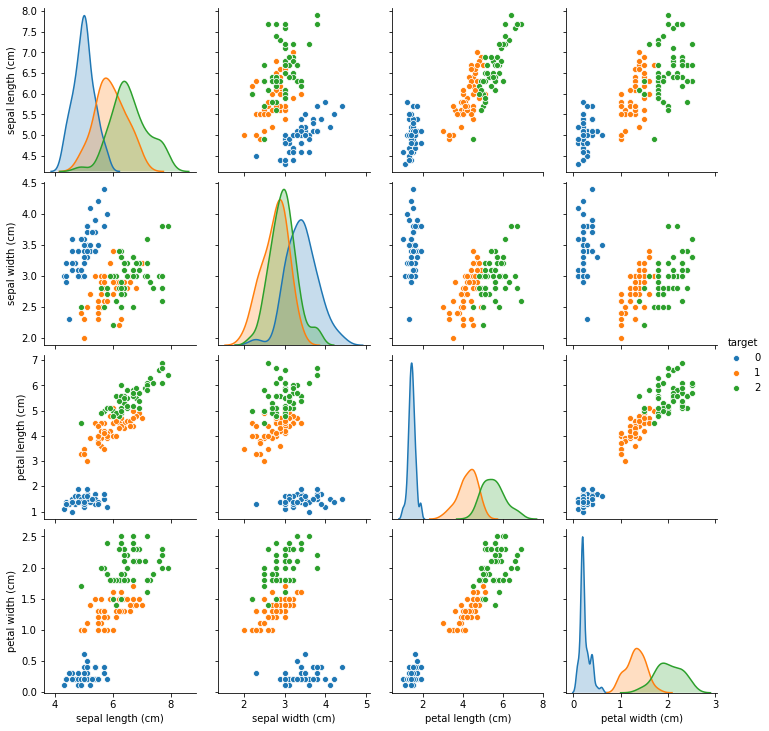

In [4]:
sns.pairplot(df, hue='target')

## Assign binary target

In [5]:
df.loc[df['target']==2, 'bin_target'] = 1
df.loc[df['target']!=2, 'bin_target'] = 0

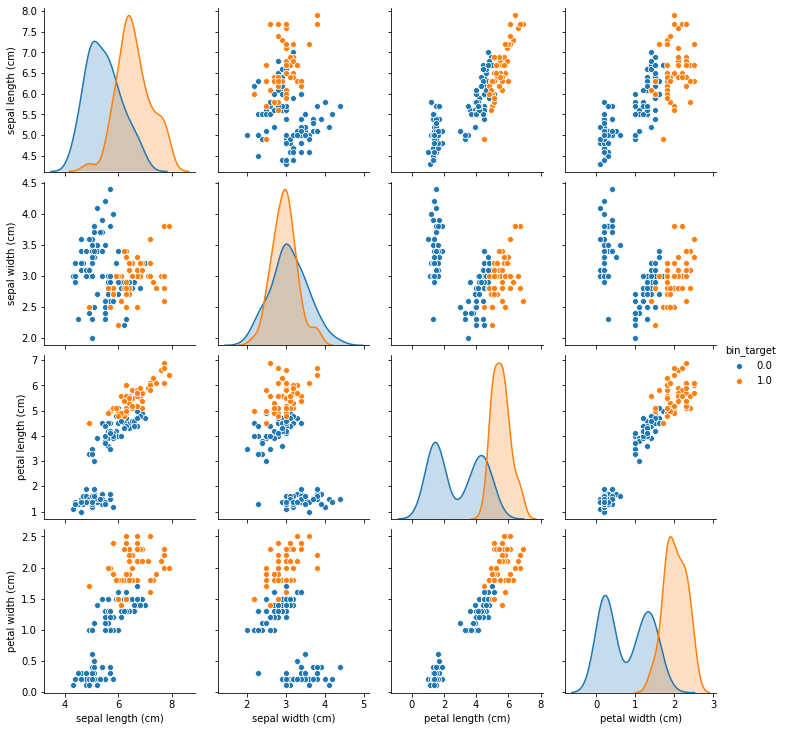

In [6]:
scatter_cols = ['sepal length (cm)',
                'sepal width (cm)',
                'petal length (cm)',
                'petal width (cm)']
col_col = 'bin_target'
pair_plot = sns.pairplot(df[scatter_cols+[col_col]], hue=col_col)
pair_plot.axes;

### mark points covered by rule

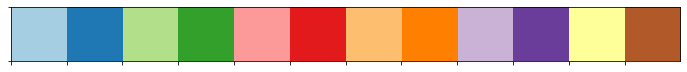

In [7]:
sns.palplot(sns.color_palette("Paired"))

In [8]:
def assign_result(data, rule_attr, attr_min=None, attr_max=None):
    df = data

    df['rule_flag'] = 0
    df.loc[df[rule_attr].between(attr_min, attr_max, inclusive=True), 'rule_flag'] = 1

    df.loc[(df['rule_flag'] == 0) & (df['bin_target'] == 0), 'result'] = 'True Negatives'
    df.loc[(df['rule_flag'] == 1) & (df['bin_target'] == 0), 'result'] = 'Falsely covered'
    df.loc[(df['rule_flag'] == 0) & (df['bin_target'] == 1), 'result'] = 'Not covered'
    df.loc[(df['rule_flag'] == 1) & (df['bin_target'] == 1), 'result'] = 'Rightly covered'


def create_colormap():
    cmap = sns.color_palette("Paired")

    # scatter plot rule results
    col_col = 'result'
    cmap = {
        'True Negatives': cmap[0],
        'Falsely covered': cmap[1],
        'Not covered': cmap[2],
        'Rightly covered': cmap[3]
    }
#     cmap = {
#         'True Negatives': 'C0',
#         'Falsely covered': 'C3',
#         'Not covered': 'C4',
#         'Rightly covered': 'C2'
#     }

    return cmap

def scatter_rule(data, scatter_cols, rule_attr, attr_min=None, attr_max=None):
    df = data

    # assign rule results
    if attr_min is None:
        attr_min = df[rule_attr].min()

    if attr_max is None:
        attr_max = df[rule_attr].max()
    assign_result(df, rule_attr, attr_min, attr_max)
    
    # scatter plot rule results
    col_col = 'result'
    cmap = create_colormap()
    
    pair_plot = sns.pairplot(df[scatter_cols+[col_col]],
                             hue=col_col,
                             palette=cmap,
                             diag_kind='hist',
                             diag_kws={'alpha': 0.7})
    # plot rule coverage
    col_axes = pair_plot.axes[:, scatter_cols.index(rule_attr)]
    row_axes = pair_plot.axes[scatter_cols.index(rule_attr), :]
    for ax in col_axes:
        ax.axvspan(attr_min, attr_max, alpha=0.2, color='C1')
    for ax in row_axes:
        ax.axhspan(attr_min, attr_max, alpha=0.2, color='C1')
    plt.show()
    print_additional_stats(df)
    
def print_additional_stats(data):
    conf_mat = pd.crosstab(data['bin_target'], data['rule_flag'])
    result_counts = data['result'].value_counts()

    confidence = result_counts['Rightly covered'] / (result_counts['Falsely covered'] + result_counts['Rightly covered'])
    support = data['rule_flag'].sum()/len(data)
    target_rate = data['bin_target'].sum()/len(data)
    lift = confidence / target_rate
    recall = result_counts['Rightly covered'] / (result_counts['Not covered'] + result_counts['Rightly covered'])
    print(f'''
    Rule confidence: {confidence: 0.3f}
    Support:         {support: 0.3f}
    Lift:            {lift: 0.3f}
    Recall:          {recall:0.3f}
    -----------------------------''')
    display(conf_mat, data['result'].value_counts())

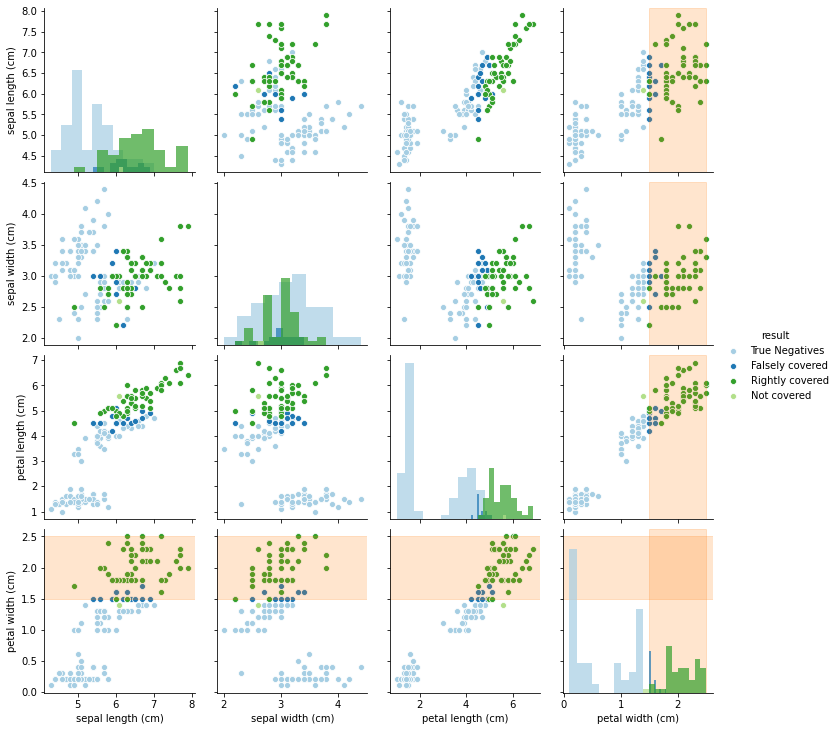


    Rule confidence:  0.766
    Support:          0.427
    Lift:             2.297
    Recall:          0.980
    -----------------------------


rule_flag,0,1
bin_target,,
0.0,85,15
1.0,1,49


True Negatives     85
Rightly covered    49
Falsely covered    15
Not covered         1
Name: result, dtype: int64

In [9]:
rule_attr = 'petal width (cm)'
attr_min = 1.5
attr_max = None
scatter_cols = ['sepal length (cm)',
            'sepal width (cm)',
            'petal length (cm)',
            'petal width (cm)']
scatter_rule(df, scatter_cols, rule_attr, attr_min, attr_max)